In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the Data

In [2]:
train_data = pd.read_csv(r"C:\Users\Pratikk\OneDrive\Desktop\House prediction\train.csv")
test_data = pd.read_csv(r"C:\Users\Pratikk\OneDrive\Desktop\House prediction\test.csv")

In [3]:
print("Train columns:", train_data.columns)
print("Test columns:", test_data.columns)

Train columns: Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCon

# Feature Engineering

In [4]:
def feature_engineering(df):
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    df = df.drop(['Id'], axis=1)
    return df

In [5]:
#Applying feature engineering in both test and training data
train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

X = train_data.drop('SalePrice', axis=1)
y = train_data['SalePrice']

In [6]:
#Spliting of data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#defining categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

In [8]:
# Create transformers for preprocessing
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [9]:
# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Set up a pipeline with XGBRegressor

In [10]:
# Building the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

In [11]:
# Define the parameter grid
param_grid = {
    'regressor__n_estimators': [200, 300, 400],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.1, 0.2],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}

In [13]:
# Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmt...
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             param_grid={'regressor__colsample_bytree': [0.8, 1.0],
                         'regressor__learning_rate': [0.1, 0.2],
                         'regressor__max_depth': [3, 5, 7],
                         'regressor__n_estimators': [200, 300, 400],
                         'regressor__subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [14]:
# Best parameters
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 300, 'regressor__subsample': 0.8}


In [15]:
# Evaluation
best_model = grid_search.best_estimator_
rmse = np.sqrt(-cross_val_score(best_model, X_valid, y_valid, cv=5, scoring='neg_mean_squared_error').mean())
print("Validation RMSE: ", rmse)
# 33329.66580361749

C:\Users\Pratikk\anaconda3\Lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: ['PoolQC']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
C:\Users\Pratikk\anaconda3\Lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: ['PoolQC']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


Validation RMSE:  33547.901733997416


In [16]:
# Predicting on the test set
predictions = best_model.predict(test_data)

In [17]:
# Creating a submission file
submission = pd.DataFrame({
    "Id": pd.read_csv(r"C:\Users\Pratikk\OneDrive\Desktop\House prediction\test.csv")["Id"],
    "SalePrice": predictions
})

submission.to_csv('submission.csv', index=False)

# Visualization

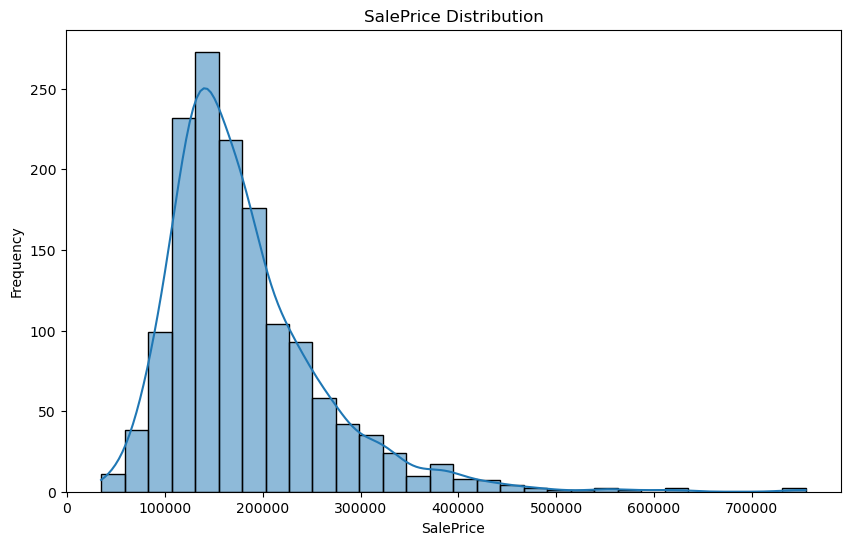

In [18]:
# SalePrice Distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], bins=30, kde=True)
plt.title('SalePrice Distribution')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

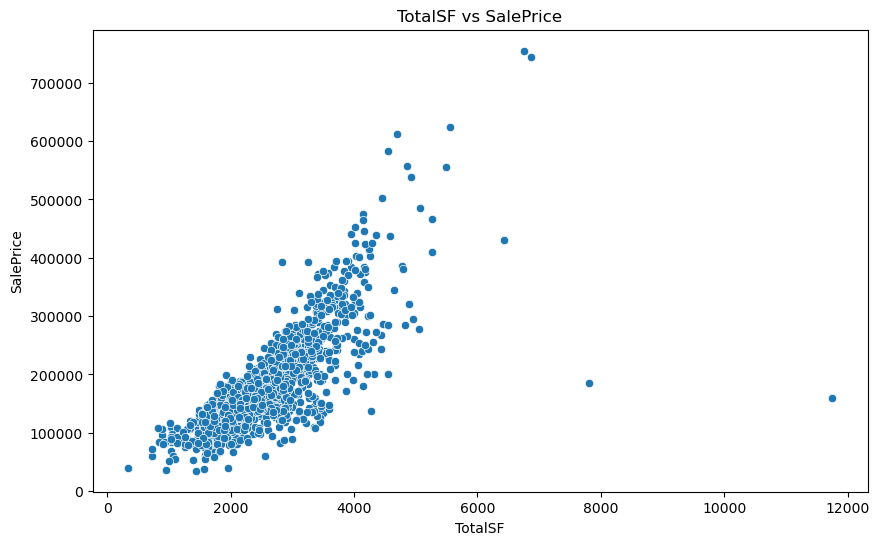

In [19]:
# TotalSF vs SalePrice
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalSF', y='SalePrice', data=train_data)
plt.title('TotalSF vs SalePrice')
plt.xlabel('TotalSF')
plt.ylabel('SalePrice')
plt.show()

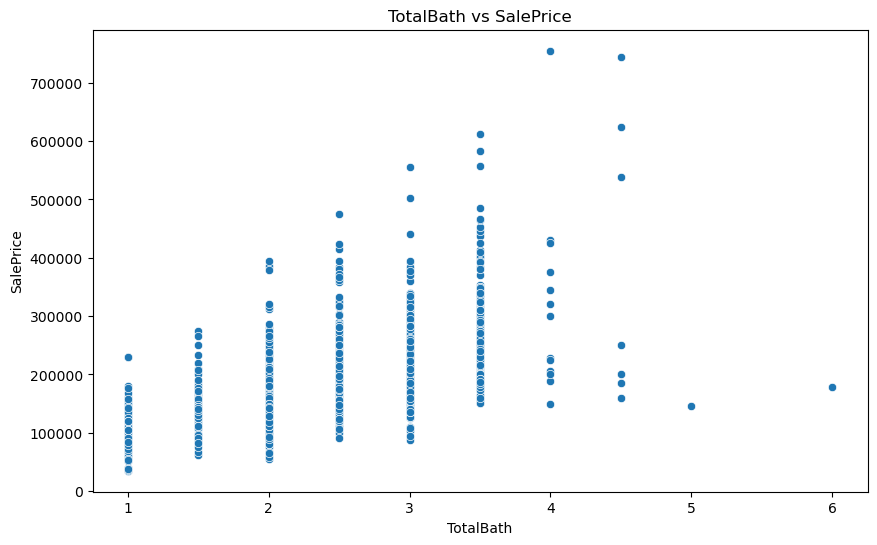

In [20]:
# TotalBath vs SalePrice
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalBath', y='SalePrice', data=train_data)
plt.title('TotalBath vs SalePrice')
plt.xlabel('TotalBath')
plt.ylabel('SalePrice')
plt.show()

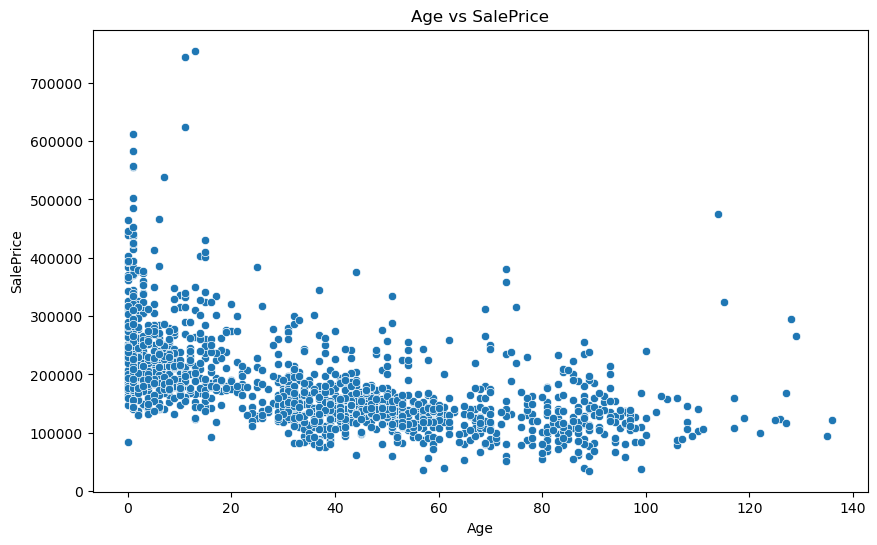

In [21]:
# Age vs SalePrice
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='SalePrice', data=train_data)
plt.title('Age vs SalePrice')
plt.xlabel('Age')
plt.ylabel('SalePrice')
plt.show()

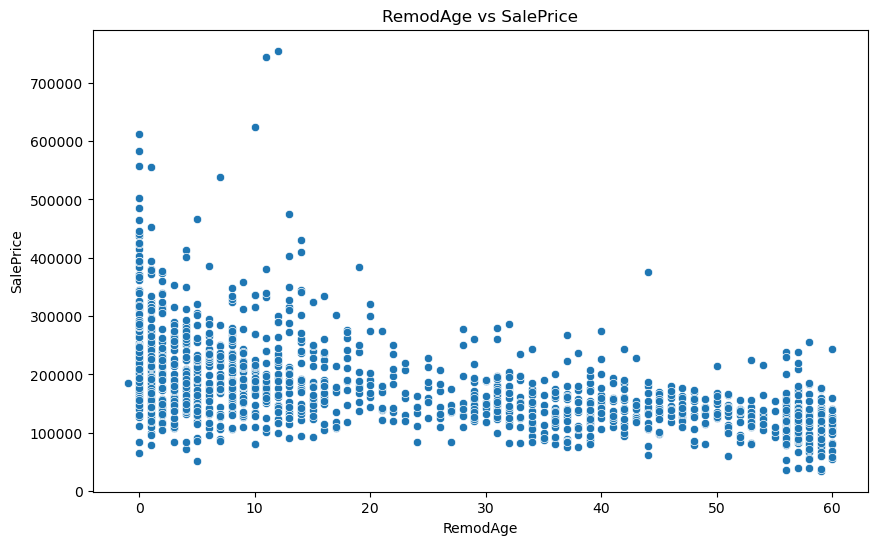

In [22]:
# RemodAge vs SalePrice
plt.figure(figsize=(10, 6))
sns.scatterplot(x='RemodAge', y='SalePrice', data=train_data)
plt.title('RemodAge vs SalePrice')
plt.xlabel('RemodAge')
plt.ylabel('SalePrice')
plt.show()